# Starting Kit - Relevance 

TODOs: 
- Add detailed description of the challenge
- describe your data
- describe how you will evaluate
- provide instructions to the participants about what they should do

***
# Setup
***
`COLAB` determines whether this notebook is running on Google Colab.

In [1]:
COLAB='google.colab' in str(get_ipython())

In [2]:
if COLAB:
    # clone github repo
    !git clone https://github.com/ihsaan-ullah/M1-Challenge-Class-2024.git

    # move to the HEP starting kit folder
    %cd M1-Challenge-Class-2024/Relevance/Starting_Kit/

    !pip install -q --upgrade sentence-transformers transformers

***
# Imports
***

In [3]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ast
from tqdm.notebook import tqdm

from sentence_transformers import SentenceTransformer

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from scipy.stats import kendalltau

import torch

import warnings
warnings.filterwarnings("ignore")
tqdm.pandas()

***
# Directories
***

In [4]:
root_dir = "./"
# Input data directory to read training data from
input_dir = root_dir + "sample_data/"
# Reference data directory to read test labels from
reference_dir = root_dir + "sample_data/"
# Output data directory to write predictions to
output_dir = root_dir + "sample_result_submission"
# Program directory
program_dir = root_dir + "ingestion_program"
# Score directory
score_dir = root_dir + "scoring_program"
# Directory to read submitted submissions from
submission_dir = root_dir + "sample_code_submission"

***
# Add directories to path
***

In [5]:
sys.path.append(input_dir)
sys.path.append(reference_dir)
sys.path.append(output_dir)
sys.path.append(program_dir)
sys.path.append(submission_dir)

***
# Data
***
1. Load Data
2. Preprocess data


TODOS:
- show data statistics

### ⚠️ Note:
The data used here is sample data is for demonstration only to get a view of what the data looks like.

In [6]:
class Data():

  def __init__(self):

      self.df = None

      print("==========================================")
      print("Data")
      print("==========================================")

  def load_data(self):
    """
      Loads data from csv file
    """
    print("[*] Loading Data")

    # data file path
    data_file = os.path.join(input_dir, 'relevance_sample_data.csv')
    
    # read data
    self.df = pd.read_csv(data_file)


  def _text_to_dict(self, text):
    """
    Converts a text string into a dictionary.

    :param text: A string representation of a dictionary.
    :return: A dictionary object if conversion is successful, otherwise {}.
    """
    try:
      return ast.literal_eval(text)
    except:
      return {}  # Return an empty dictionary in case of an error
    
  def _dict_to_paragraphs(self, dictionary):
    """
    Converts a dictionary into a string of paragraphs.

    :param dictionary: A dictionary.
    :return: A string composed of paragraphs based on the dictionary's key-value pairs.
    """
    text = ''
    for i, (k, v) in enumerate(dictionary.items()):
        text += k.capitalize() + '\n' + v + '\n'
    return text
  
  def transfrom_data(self):

    print("[*] Transforming Data")
    
    # Convert to dictionary
    self.df['most_relevant_dict'] = self.df['most_relevant'].apply(self._text_to_dict)
    self.df['second_most_relevant_dict'] = self.df['second_most_relevant'].apply(self._text_to_dict)
    self.df['second_least_relevant_dict'] = self.df['second_least_relevant'].apply(self._text_to_dict)
    self.df['least_relevant_dict'] = self.df['least_relevant'].apply(self._text_to_dict)


    # Convert from dictionary to text
    self.df['most_relevant_text'] = self.df['most_relevant_dict'].apply(self._dict_to_paragraphs)
    self.df['second_most_relevant_text'] = self.df['second_most_relevant_dict'].apply(self._dict_to_paragraphs)
    self.df['second_least_relevant_text'] = self.df['second_least_relevant_dict'].apply(self._dict_to_paragraphs)
    self.df['least_relevant_text'] = self.df['least_relevant_dict'].apply(self._dict_to_paragraphs)


  def _get_embeddings(self, text1, text2):
    """
    Generates embeddings for two texts.

    :param text1: First text string.
    :param text2: Second text string.
    :return: Tuple of embeddings for text1 and text2.
    """
    embedding1 = self.embeddings_model.encode(text1, convert_to_tensor=True)
    embedding2 = self.embeddings_model.encode(text2, convert_to_tensor=True)
    return embedding1.cpu(), embedding2.cpu()
  
  def prepare_data(self):

    print("[*] Prepare Data for Training")
    
    model_name = 'paraphrase-MiniLM-L6-v2'
    device = "cuda" if torch.cuda.is_available() else "cpu"
    self.embeddings_model = SentenceTransformer(model_name, device=device)

    # Create embeddings for each pair
    self.df['most_relevant_embeddings'] = self.df.progress_apply(lambda row: self._get_embeddings(row['prompt'], row['most_relevant_text']), axis=1)
    self.df['second_most_relevant_embeddings'] = self.df.progress_apply(lambda row: self._get_embeddings(row['prompt'], row['second_most_relevant_text']), axis=1)
    self.df['second_least_relevant_embeddings'] = self.df.progress_apply(lambda row: self._get_embeddings(row['prompt'], row['second_least_relevant_text']), axis=1)
    self.df['least_relevant_embeddings'] = self.df.progress_apply(lambda row: self._get_embeddings(row['prompt'], row['least_relevant_text']), axis=1)

    # Label the Data
    self.df['most_relevant_label'] = 3
    self.df['second_most_relevant_label'] = 2
    self.df['second_least_relevant_label'] = 1
    self.df['least_relevant_label'] = 0

    X = self.df['most_relevant_embeddings'].tolist() + self.df['second_most_relevant_embeddings'].tolist() + self.df['second_least_relevant_embeddings'].tolist() + self.df['least_relevant_embeddings'].tolist()
    y = self.df['most_relevant_label'].tolist() + self.df['second_most_relevant_label'].tolist() + self.df['second_least_relevant_label'].tolist() + self.df['least_relevant_label'].tolist()

    # Convert embeddings from tuples to concatenated arrays
    X = [torch.abs(embeddings[0] - embeddings[1]).numpy() for embeddings in X]

    # Shuffle X and y
    X, y = shuffle(X, y, random_state=42)

    # train test split
    self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.2, random_state=42)


  def get_train_data(self):
    return self.X_train, self.y_train
  
  def get_test_data(self):
    return self.X_test, self.y_test
  
  def show_random_sample(self):
    random_sample_index = np.random.randint(0, len(self.df))

    print("Prompt:\n", self.df.iloc[random_sample_index]['prompt'], "...\n")
    print("Most Relevant Text:\n", self.df.iloc[random_sample_index]['most_relevant_text'][:300], "...\n")
    print("Second Most Relevant Text:\n", self.df.iloc[random_sample_index]['second_most_relevant_text'][:300], "...\n")
    print("Second Least Relevant Text:\n", self.df.iloc[random_sample_index]['second_least_relevant_text'][:300], "...\n")
    print("Least Relevant Text:\n", self.df.iloc[random_sample_index]['least_relevant_text'][:300], "...\n")


  def show_data_stats(self):
    print("X_train shape: ", np.shape(self.X_train))
    print("y_train shape: ", np.shape(self.y_train))
    print("X_test shape: ", np.shape(self.X_test))
    print("y_test shape: ", np.shape(self.y_test))
    
  def get_data_viz(self):
    prompt_len = self.df['prompt'].apply(len)
      
    most_relevant_text_len = self.df['most_relevant_text'].apply(len)
    second_most_relevant_text_len = self.df['second_most_relevant_text'].apply(len)
    second_least_relevant_text_len = self.df['second_least_relevant_text'].apply(len)
    least_relevant_text_len = self.df['least_relevant_text'].apply(len)

    texts_len = most_relevant_text_len + second_most_relevant_text_len + second_least_relevant_text_len + least_relevant_text_len
    return prompt_len, texts_len

In [7]:
# Initilaize data
data = Data()

Data


In [8]:
# load data
data.load_data()

[*] Loading Data


In [9]:
# transform data
data.transfrom_data()

[*] Transforming Data


In [10]:
# prepare data
data.prepare_data()

[*] Prepare Data for Training


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [11]:
# show random sample from data
data.show_random_sample()

Prompt:
 Write a systematic survey or overview about the implications of the euro crisis for democracy, analyzing the conceptions and evaluations of democracy in different regions of Europe under the impact of the crisis and its effect on citizens' support for democratic principles. ...

Most Relevant Text:
 Title
The implications of the euro crisis for democracy
Abstract
ABSTRACT The question of whether European democracy is in crisis is not new, but is posed in a new way in the shadow of the euro crisis. In the tradition of the studies of democratic support and disaffection and based on data from the  ...

Second Most Relevant Text:
 Title
Learned Democracy? Support of Democracy in Central and Eastern Europe
Abstract
In this article, the extent of support for democracy is determined for thirteen countries in Central and Eastern Europe as well as in East Germany. In addition, West Germany, representing an established democracy, i ...

Second Least Relevant Text:
 Title
THE HISTORIC BA

In [12]:
# get train test data
X_train, y_train = data.get_train_data()
X_test, Y_test = data.get_test_data()

In [13]:
data.show_data_stats()

X_train shape:  (1600, 384)
y_train shape:  (1600,)
X_test shape:  (400, 384)
y_test shape:  (400,)


***
# Visualize

##### Here we plot the length histograms of the prompts and the texts.
##### We also visualize 5 random samples using word cloud.

In [14]:
import importlib

def check_and_install_wordcloud():
    try:
        importlib.import_module('wordcloud')
        print("Wordcloud is already installed.")
    except ImportError:
        print("Wordcloud is not installed. Installing...")
        !pip install wordcloud
        print("Wordcloud has been successfully installed.")

# Check and install Wordcloud
check_and_install_wordcloud()

Wordcloud is not installed. Installing...
   ---------------------------------------- 0.0/300.6 kB ? eta -:--:--
   - -------------------------------------- 10.2/300.6 kB ? eta -:--:--
   - -------------------------------------- 10.2/300.6 kB ? eta -:--:--
   --------- ----------------------------- 71.7/300.6 kB 563.7 kB/s eta 0:00:01
   ------------------------------------ --- 276.5/300.6 kB 1.7 MB/s eta 0:00:01
   ---------------------------------------- 300.6/300.6 kB 1.4 MB/s eta 0:00:00
Wordcloud has been successfully installed.


In [15]:
from wordcloud import WordCloud

class Visualize():

    def __init__(self, data):

        print("==========================================")
        print("Visualize")
        print("==========================================")
        self.data = data


    def visualize_data(self):
        prompt_len, texts_len = data.get_data_viz()
        plt.figure(figsize=(10,3))
        
        plt.hist(prompt_len, bins=range(min(prompt_len), max(prompt_len) + 1, 10), edgecolor='black')
        plt.xlabel('String Length')
        plt.ylabel('Frequency')
        plt.title('Histogram of Prompt Lengths - Avg length = ' + str(round(prompt_len.mean())))
        plt.show()

        plt.figure(figsize=(10,3))
        plt.hist(texts_len, bins=range(min(texts_len), max(texts_len) + 1, 500), color='red', edgecolor='black')
        plt.xlabel('String Length')
        plt.ylabel('Frequency')
        plt.title('Histogram of Texts Lengths - Avg length = ' + str(round(texts_len.mean())))
        plt.show()

        random_array = np.random.randint(0, len(self.data.df), size=5)
        data_df = data.df.iloc[random_array]
        columns = ['prompt', 'most_relevant_text', 'second_most_relevant_text', 'second_least_relevant_text', 'least_relevant_text']

        # Iterate through rows in the DataFrame
        for index, row in data_df.iterrows():
            plt.figure(figsize=(12, 8))
            
            # Create a WordCloud for each column
            for i, column in enumerate(columns, 1):
                plt.subplot(2, 3, i)
                wordcloud = WordCloud(width=400, height=400, background_color='white').generate(row[column])
                plt.imshow(wordcloud, interpolation='bilinear')
                plt.title(f'{column}')
                plt.axis('off')

            print((f'Relevance WordClouds for Prompt: {row["prompt"]}'))
            plt.show()


Visualize


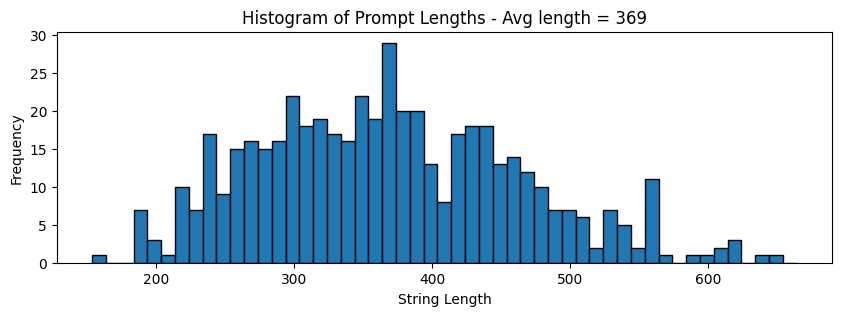

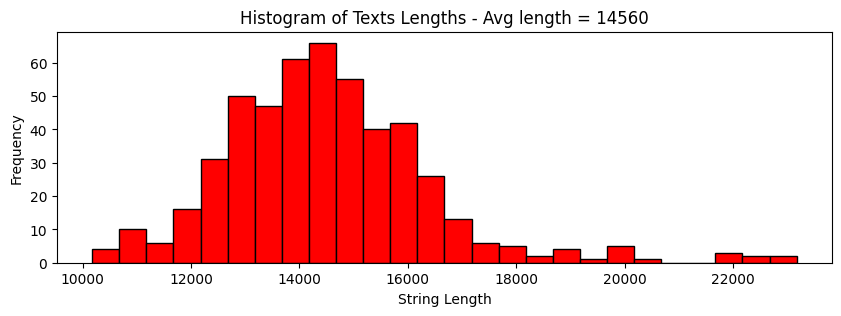

Relevance WordClouds for Prompt: Write a systematic survey or overview about the potential occupational hazards of engineered nanoparticles in the workplace, addressing critical questions such as hazard classification, exposure metrics, engineering controls, surveillance programs, and the evaluation of safety and hazards. This survey aims to sharpen the focus on occupational safety and health in nanotechnology, identifying knowledge gaps and potential areas for further research and regulation.


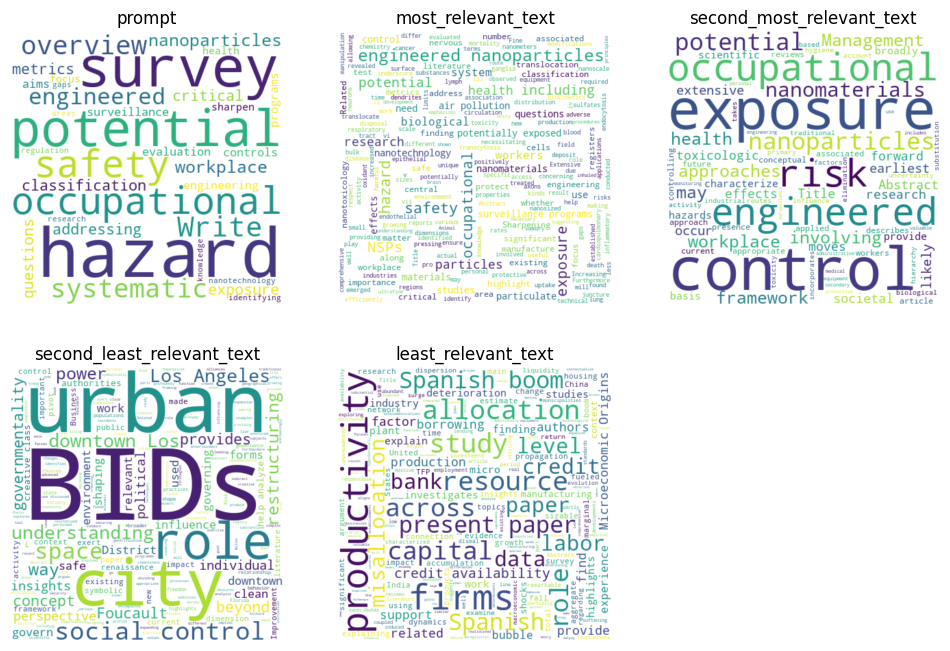

Relevance WordClouds for Prompt: Write a systematic survey or overview about the influence of urban security on transportation choices and travel behavior of citizens in the Dominican Republic, including the impact of perceived safety on demographic factors, transportation modes, and experiences of crime-related incidents during urban trips.


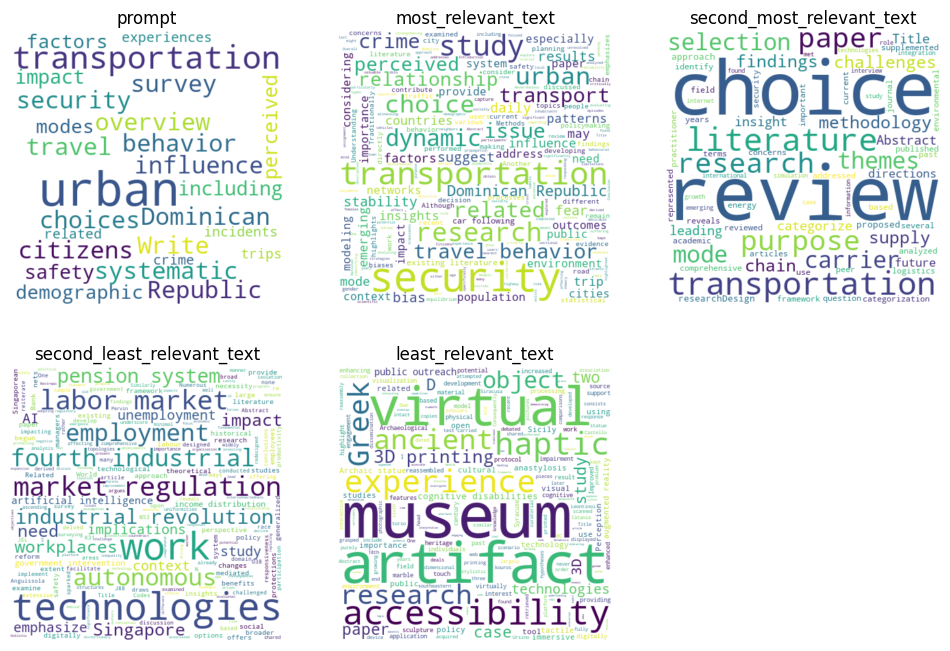

Relevance WordClouds for Prompt: Write a systematic survey or overview about the various approaches and methods used to assess L2 speech act production in the field of contrastive pragmatics and second language (L2) pragmatics. Compare and contrast the different theoretical frameworks, assessment tools, and empirical studies that have been conducted to understand L2 learners' ability to produce speech acts in a second language.


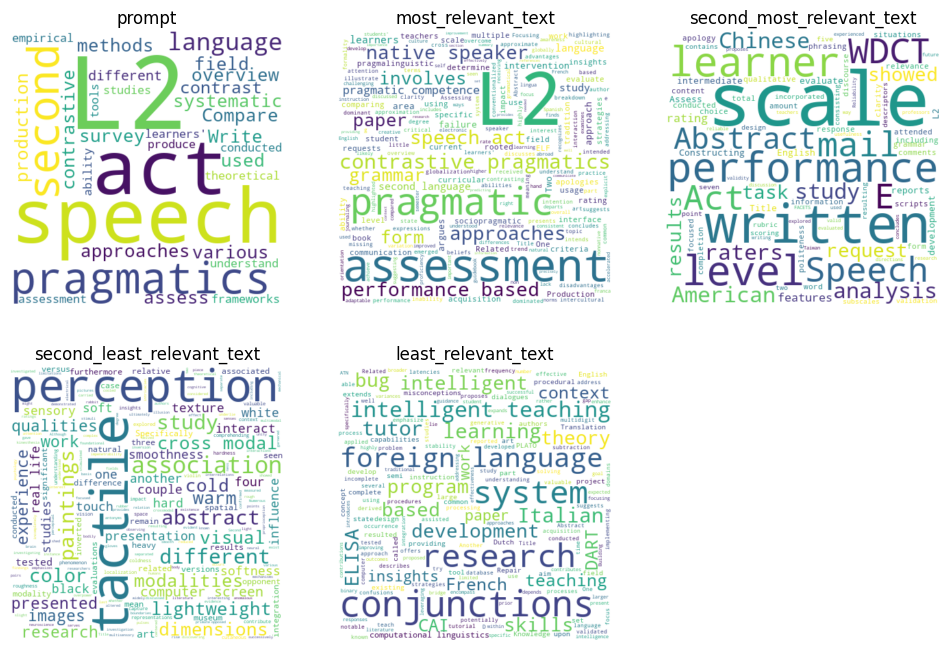

Relevance WordClouds for Prompt: Write a systematic survey or overview about the current state of research in computing prosodic morphology, including its applications, challenges, and potential future developments. Discuss the impact of prosodic morphology on natural language processing, speech recognition, and other related fields.


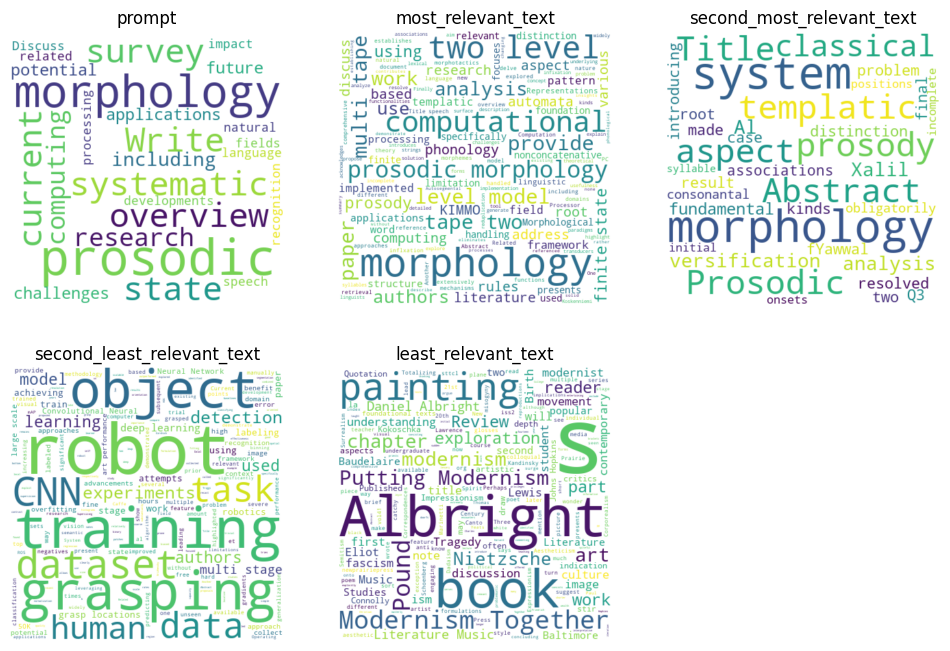

Relevance WordClouds for Prompt: Write a systematic survey or overview about the current state of federated learning techniques used in aerial-ground air quality sensing frameworks with UAV swarms, including the challenges, advancements, and potential applications in environmental monitoring and management.


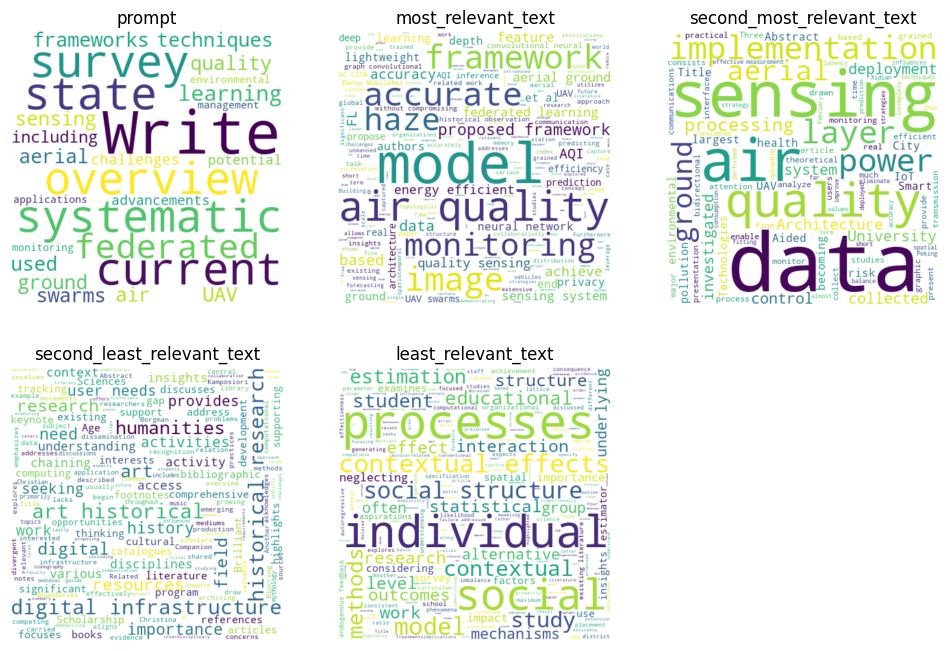

In [16]:
# Initilaize Visualize
visualize = Visualize(data=data)
visualize.visualize_data()

***
# Import Submission Model
***
We import a class named `Model` from the submission file (`model.py`). This `Model` class has the following methods:
- `init`: initializes classifier
- `fit`: gets train data and labels as input to train the classifier
- `predict`: gets test data and outputs predictions made by the trained classifier


In this example code, the `Model` class implements a Gradient Boosting Classifier model. You can find the code in `M1-Challenge-Class-2024/Relevance/Starting_Kit/sample_code_submission/model.py`. You can modify it the way you want, keeping the required class structure and functions there. More instructions are given inside the `model.py` file. If running in Collab, click the folder icon in the left sidebar to open the file browser.

In [15]:
from model import Model

***
# Program
***
**`Ingestion program`** is responsible to run the submission of a participant on Codabench platform. **`Program`** is a simplified version of the **Ingestion Program** to show to participants how it runs a submission.
1. Train a model on train data
2. Predict using Test data

In [16]:
class Program():

    def __init__(self, data):

        # used to keep object of Model class to run the submission
        self.model = None
        # object of Data class used here to get the train and test sets
        self.data = data

        # results
        self.results = []

        print("==========================================")
        print("Program")
        print("==========================================")
    
    def initialize_submission(self):
        print("[*] Initializing Submmited Model")
        self.model = Model()

    def fit_submission(self):
        print("[*] Calling fit method of submitted model")
        X_train, y_train  = self.data.get_train_data()
        self.model.fit(X_train, y_train)


    def predict_submission(self):
        print("[*] Calling predict method of submitted model")
      
        X_test, _ = self.data.get_test_data()
        self.y_test_hat = self.model.predict(X_test)

       

In [17]:
# Intiialize Program
program = Program(data=data)

Program


In [18]:
# Initialize submitted model
program.initialize_submission()

[*] Initializing Submmited Model
[*] - Initializing Classifier


In [19]:
# Call fit method of submitted model
program.fit_submission()

[*] Calling fit method of submitted model
[*] - Training Classifier on the train set


In [20]:
# Call predict method of submitted model
program.predict_submission()

[*] Calling predict method of submitted model
[*] - Predicting test set using trained Classifier


***
# Score
***

The model’s performance is evaluated using several metrics, including precision, recall, F1-score, and Kendall’s Tau. These metrics provide a comprehensive view of the model’s performance across all classes. Precision measures the model’s exactness, recall measures its completeness, the F1-score balances precision and recall, and Kendall’s Tau measures the correlation between the predicted and actual rankings. 

1.	Precision: Precision is the ratio of correctly predicted positive observations to the total predicted positives. It is also known as Positive Predictive Value. It is a measure of a classifier’s exactness. Low precision indicates a high number of false positives.

2.	Recall (Sensitivity): Recall is the ratio of correctly predicted positive observations to all the actual positives. It is also known as Sensitivity, Hit Rate, or True Positive Rate. It is a measure of a classifier’s completeness. Low recall indicates a high number of false negatives.

3.	F1 Score: The F1 Score is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. It is suitable for uneven class distribution problems.

4.	Support: Support is the number of actual occurrences of the class in the specified dataset. Imbalanced support in the training data may indicate structural weaknesses in the reported scores of the classifier and could indicate the need for stratified sampling or rebalancing.

5.	Accuracy: Accuracy is the most intuitive performance measure. It is simply a ratio of correctly predicted observation to the total observations. One may think that if we have high accuracy then our model is best. Yes, accuracy is a great measure but only when you have symmetric datasets where values of false positive and false negatives are almost the same.

6.	Macro Avg: Macro-average method can be used when you want to know how the model performs overall across the sets of data. You should not come up with any specific decision with this average.

7.	Weighted Avg: In contrary to macro-average method, if you want to know how the model is performing with respect to the most frequent class, you should use a weighted-average method. This will aggregate the contributions of all classes to compute the average metric.

8.	Kendall’s Tau: Kendall’s Tau is a measure of correlation. It gives a value between -1 and 1. A value close to 1 means that there’s a strong positive correlation between the two variables, and a value close to -1 means that there’s a strong negative correlation. A value close to 0 means that there’s no correlation. In your case, the value is approximately 0.70, indicating a good agreement.

More info in: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html


In [21]:
class Score():

    def __init__(self, data, program):

        self.data = data
        self.program = program

        print("==========================================")
        print("Score")
        print("==========================================")

    def compute_scores(self):
        print("[*] Computing scores")

        _, y_test = self.data.get_test_data()
        y_test_hat = self.program.y_test_hat

        # Classification report
        print(classification_report(y_test, y_test_hat))

        k_tau, _ = kendalltau(y_test, y_test_hat)
        print(f"Kendall's Tau: {k_tau}")

In [22]:
# Initialize Score
score = Score(data=data, program=program)

Score


In [23]:
# Compute Score
score.compute_scores()

[*] Computing scores
              precision    recall  f1-score   support

           0       0.48      0.52      0.50        96
           1       0.55      0.49      0.52       107
           2       0.57      0.59      0.58        91
           3       0.75      0.75      0.75       106

    accuracy                           0.59       400
   macro avg       0.59      0.59      0.59       400
weighted avg       0.59      0.59      0.59       400

Kendall's Tau: 0.6782257738683362


***
# Submissions
***

### **Unit Testing**

It is <b><span style="color:red">important that you test your submission files before submitting them</span></b>. All you have to do to make a submission is modify the file <code>model.py</code> in the <code>sample_code_submission/</code> directory, then run this test to make sure everything works fine. This is the actual program that will be run on the server to test your submission.
<br>
Keep the sample code simple.<br>

<code>python3</code> is required for this step

### **Test Ingestion Program**

In [28]:
!python3 $program_dir/ingestion.py

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


############################################
### Ingestion Program
############################################

[*] Loading Data
[*] Transforming Data
[*] Prepare Data for Training
  0%|          | 0/500 [00:00<?, ?it/s]
[*] Initializing Submmited Model
[*] - Initializing Classifier
[*] Calling fit method of submitted model
[*] - Training Classifier on the train set
[*] Calling predict method of submitted model
[*] - Predicting test set using trained Classifier
[*] Saving ingestion result

---------------------------------
[✔] Total duration: 0:05:03.166551
---------------------------------

----------------------------------------------
[✔] Ingestions Program executed successfully!
----------------------------------------------




### **Test Scoring Program**

In [29]:
!python3 $score_dir/score.py

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


############################################
### Scoring Program
############################################

[*] Reading predictions
[✔]
[*] Computing scores
              precision    recall  f1-score   support

           0       0.50      0.56      0.53        96
           1       0.60      0.50      0.55       107
           2       0.58      0.63      0.60        91
           3       0.77      0.75      0.76       106

    accuracy                           0.61       400
   macro avg       0.61      0.61      0.61       400
weighted avg       0.61      0.61      0.61       400

Kendall's Tau: 0.6919507236667067
[✔]
[*] Writing scores
[✔]

---------------------------------
[✔] Total duration: 0:00:00.006382
---------------------------------

----------------------------------------------
[✔] Scoring Program executed successfully!
----------------------------------------------




### **Prepare the submission**

TODOs:  
- The following submission will be submitted by the participants to your competition website. Describe this clearly and point to the competition once your website is ready

In [31]:
import datetime
from data_io import zipdir
the_date = datetime.datetime.now().strftime("%y-%m-%d-%H-%M")
code_submission = 'Relevance-code_submission_' + the_date + '.zip'
zipdir(code_submission, submission_dir)
print("Submit : " + code_submission + " to the competition")
print("You can find the zip file in `M1-Challenge-Class-2024/Relevance/Starting_Kit/")

Submit : Relevance-code_submission_24-01-12-00-27.zip to the competition
You can find the zip file in `M1-Challenge-Class-2024/Relevance/Starting_Kit/
